## Demo of finding correspondences

- Demos generating correspondences in PyTorch
- Simple timing experiments in pytorch
- Demos generating non-correspondences

## Find pixel correspondences in PyTorch

Using SpartanDataset:
   - in train mode
   - number of scenes 17
   - total images:     3217
0.0304517745972 seconds


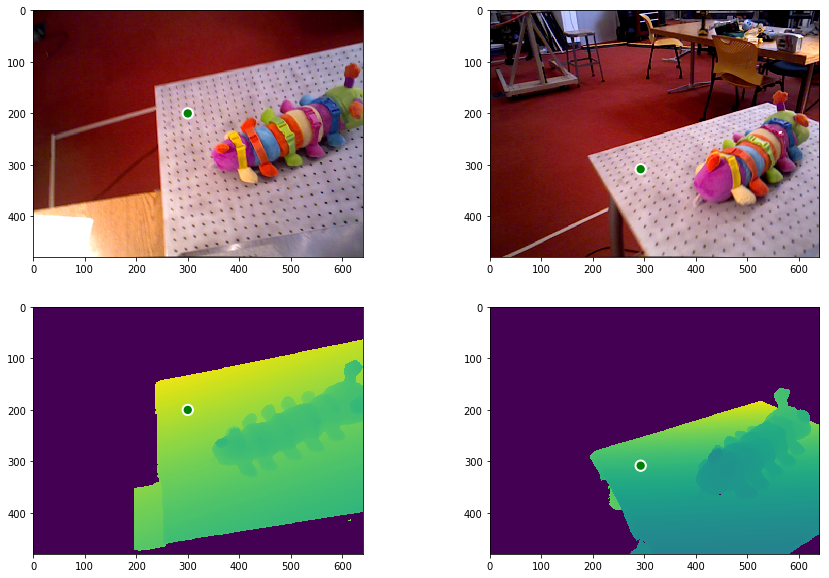

In [2]:
%matplotlib inline
import dense_correspondence_manipulation.utils.utils as utils
utils.add_dense_correspondence_to_python_path()
import correspondence_plotter
from dense_correspondence.dataset.spartan_dataset_masked import SpartanDataset
import os
import numpy as np


config_filename = os.path.join(utils.getDenseCorrespondenceSourceDir(), 'config', 'dense_correspondence', 
                               'dataset', 'composite', 'caterpillar_only.yaml')
config = utils.getDictFromYamlFilename(config_filename)
dataset = SpartanDataset(config=config)

import correspondence_finder
import time
uv_a = (300,200)

scene = "2018-04-10-16-02-59"
img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a = (300,200)
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    uv_a=uv_a)
print time.time() - start, "seconds"
if uv_a is not None:
    correspondence_plotter.plot_correspondences_direct(img_a_rgb, img_a_depth_numpy, img_b_rgb, img_b_depth_numpy, uv_a, uv_b)
else:
    print "try running this cell again, did not find a correspondence for this pixel"

## PyTorch implementation -- finding many correspondences

Note that in this example, about 1/10 get pruned due to either:

1. No depth measurement in image a
2. Reprojection is outside FOV of image b
3. Occluded: the point from image a is occluded in image b
4. No depth measurement in image b (so can't be sure if occluded or not)

0.00264286994934 seconds
num attempted:  50
num valid:      14


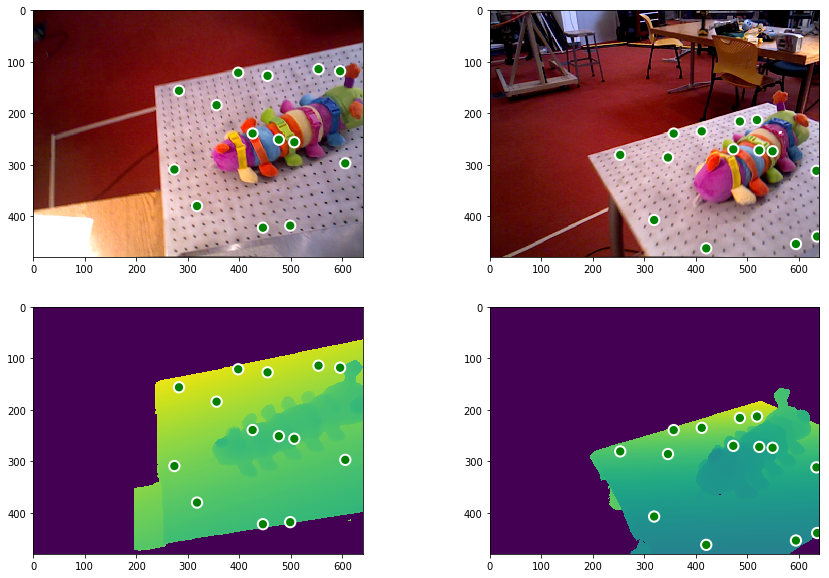

In [3]:
start = time.time()
num_attempts = 50
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose, 
                                                                    num_attempts=num_attempts)
print time.time() - start, "seconds"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])
if uv_a is not None:
    correspondence_plotter.plot_correspondences_direct(img_a_rgb, img_a_depth_numpy, img_b_rgb, img_b_depth_numpy, uv_a, uv_b)

## On CPU, how fast can we do many, many samples? (many samples, let's not plot)

In [4]:
num_attempts = 50000

img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='CPU')

print time.time() - start, "seconds 1st time"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='CPU')

print time.time() - start, "seconds 2nd time"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='CPU')
print time.time() - start, "seconds on a new image pair"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

0.00885105133057 seconds 1st time
num attempted:  50000
num valid:      22973
0.00632691383362 seconds 2nd time
num attempted:  50000
num valid:      22946
0.00576591491699 seconds on a new image pair
num attempted:  50000
num valid:      15922


## On GPU, how fast?

In [5]:
num_attempts = 50000

img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='GPU')

print time.time() - start, "seconds 1st time"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='GPU')

print time.time() - start, "seconds 2nd time"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='GPU')
print time.time() - start, "seconds on a new image pair"
print "num attempted: ", num_attempts
print "num valid:     ", len(uv_a[0])

2.03734207153 seconds 1st time
num attempted:  50000
num valid:      16672
0.00498199462891 seconds 2nd time
num attempted:  50000
num valid:      16609
0.00720810890198 seconds on a new image pair
num attempted:  50000
num valid:      10836


## Timing Comments

- Since PyTorch has an asynchronous cuda API, the timing numbers for the GPU version are not really valid
- In the end, we actually prefer to perform correspondence matching on CPU, since we can have the PyTorch multithreaded dataset loader be performing correspondence matching in parallel with no cost to the GPU, and then the GPU is reserved for just forwards-backwards passes of the network


# Non-correspondences

In [6]:
num_attempts = 5

img_a_index = dataset.get_random_image_index(scene)
img_a_rgb, img_a_depth, _, img_a_pose = dataset.get_rgbd_mask_pose(scene, img_a_index)

img_b_index = dataset.get_img_idx_with_different_pose(scene, img_a_pose, num_attempts=50)
img_b_rgb, img_b_depth, _, img_b_pose = dataset.get_rgbd_mask_pose(scene, img_b_index)

img_a_depth_numpy = np.asarray(img_a_depth)
img_b_depth_numpy = np.asarray(img_b_depth)

start = time.time()
uv_a, uv_b = correspondence_finder.batch_find_pixel_correspondences(img_a_depth_numpy, img_a_pose, 
                                                                    img_b_depth_numpy, img_b_pose,
                                                                    num_attempts=num_attempts,
                                                                    device='CPU')

start = time.time()
uv_b_non_matches = correspondence_finder.create_non_correspondences(uv_b, img_a_depth_numpy.shape, num_non_matches_per_match=10)
print  time.time() - start, "seconds for non-matches"
if uv_b_non_matches is not None:
    print uv_b_non_matches[0].shape

    import torch
    # This just checks to make sure nothing is out of bounds
    print torch.min(uv_b_non_matches[0])
    print torch.min(uv_b_non_matches[1])
    print torch.max(uv_b_non_matches[0])
    print torch.max(uv_b_non_matches[1])
    
    fig, axes = correspondence_plotter.plot_correspondences_direct(img_a_rgb, img_a_depth_numpy, img_b_rgb, img_b_depth_numpy, uv_a, uv_b, show=False)
    uv_a_long = (torch.t(uv_a[0].repeat(3, 1)).contiguous().view(-1,1), torch.t(uv_a[1].repeat(3, 1)).contiguous().view(-1,1))
    uv_b_non_matches_long = (uv_b_non_matches[0].view(-1,1), uv_b_non_matches[1].view(-1,1) )
    correspondence_plotter.plot_correspondences_direct(img_a_rgb, img_a_depth_numpy, img_b_rgb, img_b_depth_numpy, uv_a_long, uv_b_non_matches_long, use_previous_plot=(fig,axes),
                                                  circ_color='r')


0.00132393836975 seconds for non-matches
torch.Size([0, 10])


RuntimeError: invalid argument 1: tensor must have one dimension at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:574

## Note for future:

In the plot above (at least at time of this writing), you can see a potential issue that would want a little bit of a refactor.

It is currently possible for "non-matches" to sample parts of image b for which there is no known depth.

This could be an issue for example, if it just so happens that that corner of image b matches image a.

Two things though:

1. Once I have depths from the actual projection against world model, this will be less of an issue, since there will be less holes.
2. That combined with that issue hopefully being rare, means maybe I shouldn't worry about it for now.